In [41]:
import pandas as pd

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


In [42]:
train_data = pd.read_csv("train_data.csv")
test_data = pd.read_csv("test_data.csv")

train_data.head()


,date,device,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric8,metric9
0,1/1/2015,S1F01085,0,215630672,55,0,52,6,407438,0,0,7
1,1/1/2015,W1F0Y13C,0,234318640,0,0,0,4,185772,0,0,3
2,1/1/2015,W1F0XKWR,0,89660704,0,0,0,7,30,0,0,0
3,1/1/2015,W1F0X7QX,0,162013456,0,0,0,12,217686,0,0,0
4,1/1/2015,W1F0X7PR,0,13138392,0,0,0,9,191343,0,0,0


In [ ]:
#drop device comumn
train_data = train_data.drop(columns=['device'])
X_train = train_data.drop(columns=['failure'])
y_train = train_data['failure']

In [ ]:
input_dim = train_data.shape[1]-1  # Assuming last column is the target or date
encoding_dim = 16  # Dimension of encoded representation

input_layer = keras.Input(shape=(input_dim,))
encoded = layers.Dense(encoding_dim, activation="relu")(input_layer)
encoded = layers.Dense(8, activation="relu")(encoded)
encoded = layers.Dense(4, activation="relu")(encoded)

decoded = layers.Dense(8, activation="relu")(encoded)
decoded = layers.Dense(encoding_dim, activation="relu")(decoded)
decoded = layers.Dense(input_dim, activation="sigmoid")(decoded)

autoencoder = keras.Model(input_layer, decoded)
autoencoder.compile(optimizer="adam", loss="mse")

In [45]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

In [46]:
train_data = pd.read_csv("train_data.csv")
test_data = pd.read_csv("test_data.csv")

In [47]:
train_data = train_data.drop(columns=['device'])
test_data = test_data.drop(columns=['device'])

In [ ]:
train_data['date'] = pd.to_datetime(train_data['date'])
test_data['date'] = pd.to_datetime(test_data['date'])


In [49]:
X_train = train_data.drop(columns=['failure', 'date'])  # Drop 'date' if not used
y_train = train_data['failure']
X_test = test_data.drop(columns=['failure', 'date'])  # Drop 'date' if not used
y_test = test_data['failure']

In [50]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [51]:
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

In [52]:
input_dim = X_train_reshaped.shape[2]  
encoding_dim = 16  

input_layer = keras.Input(shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2]))
encoded = layers.LSTM(encoding_dim, activation="relu", return_sequences=True)(input_layer)
encoded = layers.LSTM(8, activation="relu", return_sequences=True)(encoded)
encoded = layers.LSTM(4, activation="relu")(encoded)

decoded = layers.RepeatVector(X_train_reshaped.shape[1])(encoded)
decoded = layers.LSTM(8, activation="relu", return_sequences=True)(decoded)
decoded = layers.LSTM(encoding_dim, activation="relu", return_sequences=True)(decoded)
decoded = layers.TimeDistributed(layers.Dense(input_dim))(decoded)

autoencoder = keras.Model(input_layer, decoded)
autoencoder.compile(optimizer="adam", loss="mse")


autoencoder.fit(X_train_reshaped, X_train_reshaped, epochs=50, batch_size=32, shuffle=True, validation_split=0.1)


Epoch 1/50
3436/3436 [==============================] - 16s 4ms/step - loss: 0.0043 - val_loss: 6.5106e-04
Epoch 2/50
3436/3436 [==============================] - 12s 3ms/step - loss: 5.5743e-04 - val_loss: 2.6626e-04
Epoch 3/50
3436/3436 [==============================] - 12s 3ms/step - loss: 3.7585e-04 - val_loss: 2.3571e-04
Epoch 4/50
3436/3436 [==============================] - 12s 4ms/step - loss: 3.4135e-04 - val_loss: 2.0255e-04
Epoch 5/50
3436/3436 [==============================] - 12s 3ms/step - loss: 2.3292e-04 - val_loss: 1.4613e-04
Epoch 6/50
3436/3436 [==============================] - 12s 3ms/step - loss: 1.2208e-04 - val_loss: 9.4341e-05
Epoch 7/50
3436/3436 [==============================] - 12s 3ms/step - loss: 9.5029e-05 - val_loss: 8.9755e-05
Epoch 8/50
3436/3436 [==============================] - 12s 3ms/step - loss: 9.0822e-05 - val_loss: 7.5324e-05
Epoch 9/50
3436/3436 [==============================] - 12s 4ms/step - loss: 9.4711e-05 - val_loss: 4.8724e-05
Epoch

In [ ]:
X_test_pred = autoencoder.predict(X_test_reshaped)

mse_per_sample = np.mean((X_test_reshaped - X_test_pred) ** 2, axis=(1, 2))  
rmse = np.sqrt(mse_per_sample)


threshold = np.percentile(rmse, 95) 
predictions = (rmse > threshold).astype(int)


from sklearn.metrics import classification_report, confusion_matrix

print("Confusion Matrix:")
print(confusion_matrix(y_test, predictions))
print("\nClassification Report:")
print(classification_report(y_test, predictions))

46/46 [==============================] - 0s 1ms/step
Confusion Matrix:
[[1391   74]
 [   0    0]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97      1465
           1       0.00      0.00      0.00         0

    accuracy                           0.95      1465
   macro avg       0.50      0.47      0.49      1465
weighted avg       1.00      0.95      0.97      1465



c:\Users\ahmed\anaconda3\envs\maintenance\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ahmed\anaconda3\envs\maintenance\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ahmed\anaconda3\envs\maintenance\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [57]:
! pip install seaborn

   ---------------------------------------- 0.0/8.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.0 MB ? eta -:--:--
   - -------------------------------------- 0.3/8.0 MB ? eta -:--:--
   - -------------------------------------- 0.3/8.0 MB ? eta -:--:--
   - -------------------------------------- 0.3/8.0 MB ? eta -:--:--
   -- ------------------------------------- 0.5/8.0 MB 390.7 kB/s eta 0:00:20
   -- ------------------------------------- 0.5/8.0 MB 390.7 kB/s eta 0:00:20
   -- ------------------------------------- 0.5/8.0 MB 390.7 kB/s eta 0:00:20
   --- ------------------------------------ 0.8/8.0 MB 430.4 kB/s eta 0:00:17
   --- ------------------------------------ 0.8/8.0 MB 430.4 kB/s eta 0:00:17
   ----- ---------------------------------- 1.0/8.0 MB 466.2 kB/s eta 0:00:15
   ----- ---------------------------------- 1.0/8.0 MB 466.2 kB/s eta 0:00:15
   ----- -------------------------------

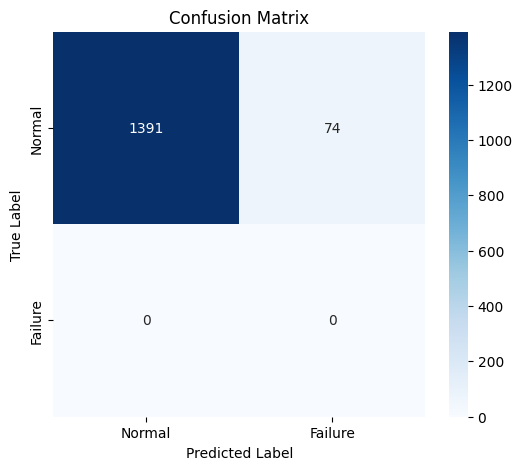

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns
cm=confusion_matrix(y_test, predictions)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Failure"], yticklabels=["Normal", "Failure"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()